# 0004.001 EDA - Goals

In [1]:
import pathlib
# import os
import sys
# import pickle
# import inspect

import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1
#add the 'src' directory to path to import modules
PROJECT_DIR = pathlib.Path.cwd().resolve().parent
sys.path.append(str(PROJECT_DIR))

from src.visualization.visualize import (extend_cols,
                                         vstacked_bar_charts,
                                         diagnose_discrete_fit)
from src.visualization.fit_dists import fit_nbinom

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

EDA_FP = PROJECT_DIR / 'data' / 'reference' / 'eda' / 'sample.csv'

In [2]:
df_orig = pd.read_csv(EDA_FP, parse_dates=['date']).sort_values(by=['date', 'h', 'a']).reset_index(drop=True)
cols = extend_cols([])
df_orig = df_orig[cols]
df_orig.head()

,nation,league,season,date,h,a,h_ftGoals,a_ftGoals,h_shots,a_shots,h_shotsOnTarget,a_shotsOnTarget,result
0,germany,bundesliga,2007-2008,2007-08-10,stuttgart,schalke,2.0,2.0,16,10,7,4,draw
1,germany,bundesliga,2007-2008,2007-08-11,bayern-munich,hansa-rostock,3.0,0.0,27,6,13,0,hwin
2,germany,bundesliga,2007-2008,2007-08-11,bochum,sv-werder-bremen,2.0,2.0,17,20,4,9,draw
3,germany,bundesliga,2007-2008,2007-08-11,eintracht-frankfurt,hertha-berlin,1.0,0.0,19,10,5,3,hwin
4,germany,bundesliga,2007-2008,2007-08-11,hannover,hamburger-sv,0.0,1.0,10,14,2,8,awin


In [3]:
df_orig.tail()

,nation,league,season,date,h,a,h_ftGoals,a_ftGoals,h_shots,a_shots,h_shotsOnTarget,a_shotsOnTarget,result
913,germany,bundesliga,2009-2010,2010-05-08,mainz,schalke,0.0,0.0,12,10,4,3,draw
914,germany,bundesliga,2009-2010,2010-05-08,nurnberg,fc-koln,1.0,0.0,13,5,3,2,hwin
915,germany,bundesliga,2009-2010,2010-05-08,sc-freiburg,dortmund,3.0,1.0,14,11,3,5,hwin
916,germany,bundesliga,2009-2010,2010-05-08,sv-werder-bremen,hamburger-sv,1.0,1.0,22,15,8,4,draw
917,germany,bundesliga,2009-2010,2010-05-08,wolfsburg,eintracht-frankfurt,3.0,1.0,16,19,7,3,hwin


In [4]:
df = df_orig.copy(deep=True)
df[['h_ftGoals', 'a_ftGoals']].describe()

,h_ftGoals,a_ftGoals
count,918.000000,918.000000
mean,1.627451,1.226580
std,1.340009,1.139588
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,8.000000,6.000000


In [5]:

n_seasons = df['season'].unique().shape[0]
n_games_per_season = len(df) // n_seasons
h_goals = df['h_ftGoals'].dropna().astype(int)
a_goals = df['a_ftGoals']
# Need to deal with any goal value that has no occurrences in any game
# eg 2 games have 5 goals | 0 games have 6 goals | 1 game has 7 goals
# !! Important to do this every freq count
max_goals = df[['h_ftGoals', 'a_ftGoals']].max().max().astype(int)
h_goals_val_counts = h_goals.value_counts()
h_goals_dist = h_goals.value_counts().sort_index(). \
                    reindex(range(max_goals+1), fill_value=0)

a_goals_val_counts_a = a_goals.value_counts()
a_goals_dist = a_goals.value_counts().sort_index(). \
                    reindex(range(max_goals+1), fill_value=0)

goals_dists = pd.concat([h_goals_dist, a_goals_dist], axis=1)

print(f'Home and Away Goals Distributions over {n_seasons} seasons with {n_games_per_season} games per season:\n\n{goals_dists}')

Home and Away Goals Distributions over 3 seasons with 306 games per season:

   h_ftGoals  a_ftGoals
0        191        283
1        292        319
2        237        185
3        106         99
4         62         21
5         22         10
6          5          1
7          2          0
8          1          0


In [6]:
h_goals_mean = df['h_ftGoals'].mean()
h_goals_var = df['h_ftGoals'].var()

a_goals_mean = df['a_ftGoals'].mean()
a_goals_var = df['a_ftGoals'].var()

print('Home Goals Distribution:\n')
print(f'Mean:\t\t{h_goals_mean}')
print(f'Variance:\t{h_goals_var}\n')

print('Away Goals Distribution:\n')
print(f'Mean:\t\t{a_goals_mean}')
print(f'Variance:\t{a_goals_var}\n')

Home Goals Distribution:

Mean:		1.6274509803921569
Variance:	1.7956251202770903

Away Goals Distribution:

Mean:		1.2265795206971677
Variance:	1.298660261390393



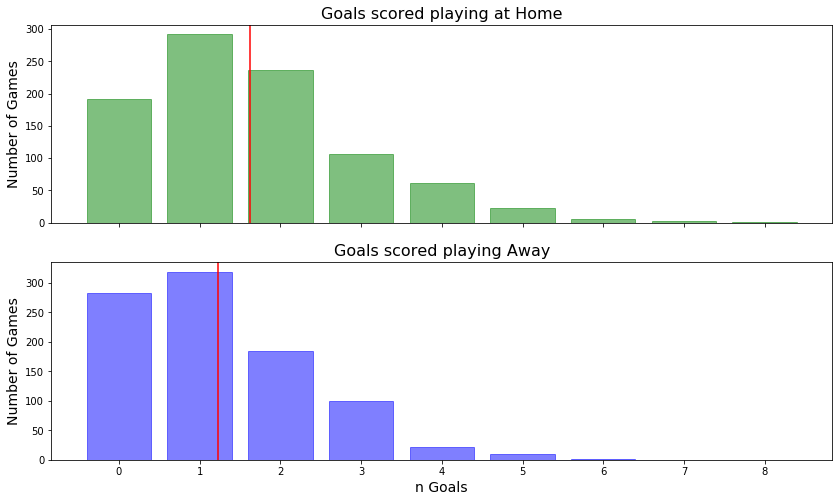

In [7]:
fig, (ax1, ax2) = vstacked_bar_charts(goals_dists.index, [goals_dists['h_ftGoals'], goals_dists['a_ftGoals']],
                                      figsize=(14,8))

ax1_bars = [rect.set_color('g') for rect in ax1.patches]
ax1.axvline(h_goals_mean, color='r')
ax1.set_title('Goals scored playing at Home', fontsize=16)
ax1.set_ylabel('Number of Games', fontsize=14)

ax2_bars = [rect.set_color('b') for rect in ax2.patches]
ax2.axvline(a_goals_mean, color='r')
ax2.set_title('Goals scored playing Away', fontsize=16)
ax2.set_ylabel('Number of Games', fontsize=14)
ax2.set_xlabel('n Goals', fontsize=14)

tick_spacing = 1
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.show();

Red Lines shows mean

The [Home Advantage](https://dashee87.github.io/data%20science/python/home-advantage-in-football-leagues-around-the-world/) effect shows up clearly in the means

For a Poisson distribution to work, we are looking for the mean and variance of each distribution to be equal.

For both home and away games - variance > mean (But not by much!), so there is possibly some overdispersion

### Home Goals Poisson Distribution Fit

Taking the mean to be equal to Poisson lambda parameter

In [8]:
# Get the expected values of a Poisson distribution with the same mu
norm_exp = stats.poisson.pmf(goals_dists.index, h_goals_mean)
exp = norm_exp * goals_dists['h_ftGoals'].sum()
h_goals_poiss = pd.DataFrame(np.vstack([goals_dists['h_ftGoals'].values, exp, norm_exp])).T
h_goals_poiss.rename(columns={0:'obs', 1:'exp', 2: 'exp_norm' }, inplace=True)
h_goals_poiss['obs_norm'] = h_goals_poiss['obs']/ h_goals_poiss['obs'].sum()
h_goals_poiss

,obs,exp,exp_norm,obs_norm
0,191.0,180.322409,0.196430,0.208061
1,292.0,293.465881,0.319680,0.318083
2,237.0,238.800668,0.260131,0.258170
3,106.0,129.545461,0.141117,0.115468
4,62.0,52.707222,0.057415,0.067538
5,22.0,17.155684,0.018688,0.023965
6,5.0,4.653339,0.005069,0.005447
7,2.0,1.081869,0.001179,0.002179
8,1.0,0.220086,0.000240,0.001089


In [9]:
# Use a Chi squared Test
# and KS Test - maybe not suitable for discrete distributions?

chi2 = stats.power_divergence(h_goals_poiss['obs'],
                              f_exp=h_goals_poiss['exp'],
                              lambda_="pearson",
                             ddof=1, axis=0)
ks = stats.kstest(h_goals_poiss['obs'],
                  'poisson',
                  [h_goals_mean])

print(f'Pearson:\n{chi2}\n')
print(f'KS:\n{ks}\n')

Pearson:
Power_divergenceResult(statistic=11.507729168882296, pvalue=0.11795440383480903)

KS:
KstestResult(statistic=0.771238916032832, pvalue=3.940944808241149e-06)



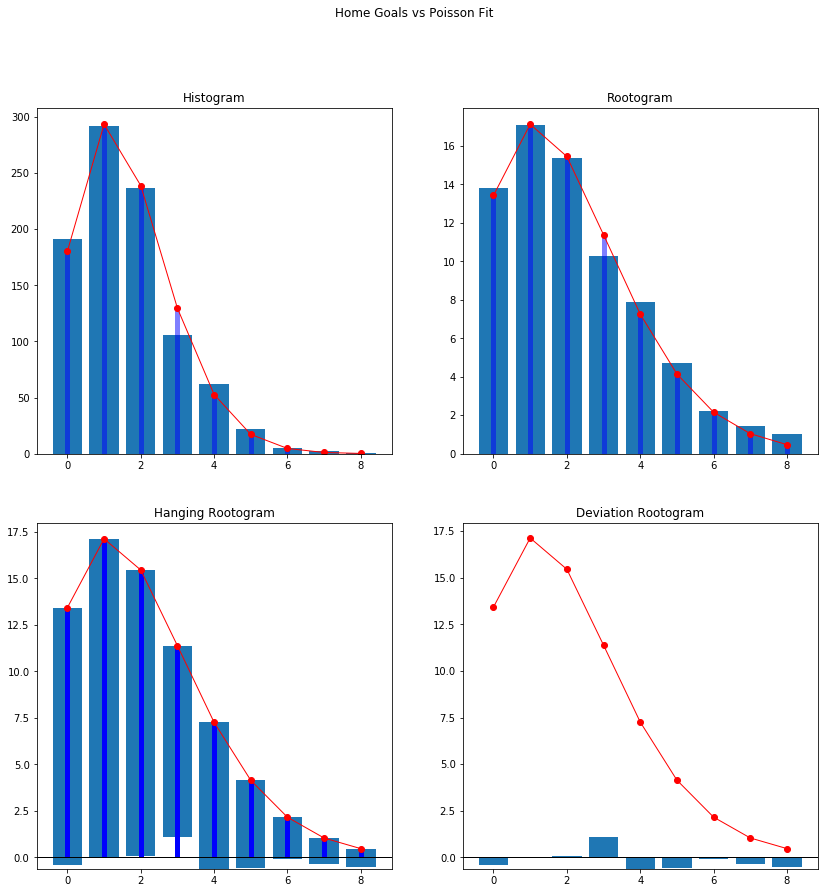

In [10]:
# plt.style.use('fivethirtyeight')
fig, axes = diagnose_discrete_fit(h_goals_poiss.index,
                                  h_goals_poiss['obs'],
                                  h_goals_poiss['exp'])
plt.suptitle('Home Goals vs Poisson Fit')

plt.show();

### Away Goals Poisson Distribution Fit

Taking the mean to be equal to Poisson lambda parameter

In [11]:
# Get the expected values of a Poisson distribution with the same mu
norm_exp = stats.poisson.pmf(goals_dists.index, a_goals_mean)
exp = norm_exp * goals_dists['a_ftGoals'].sum()
a_goals_poiss = pd.DataFrame(np.vstack([goals_dists['a_ftGoals'].values, exp, norm_exp])).T
a_goals_poiss.rename(columns={0:'obs', 1:'exp', 2: 'exp_norm' }, inplace=True)
a_goals_poiss['obs_norm'] = a_goals_poiss['obs']/ a_goals_poiss['obs'].sum()
a_goals_poiss

,obs,exp,exp_norm,obs_norm
0,283.0,269.243956,0.293294,0.308279
1,319.0,330.249123,0.359749,0.347495
2,185.0,202.538406,0.220630,0.201525
3,99.0,82.809820,0.090207,0.107843
4,21.0,25.393207,0.027661,0.022876
5,10.0,6.229358,0.006786,0.010893
6,1.0,1.273467,0.001387,0.001089
7,0.0,0.223144,0.000243,0.000000
8,0.0,0.034213,0.000037,0.000000


In [12]:
# Use a Chi squared Test
# and KS Test - maybe not suitable for discrete distributions?

chi2 = stats.power_divergence(a_goals_poiss['obs'],
                              f_exp=a_goals_poiss['exp'],
                              lambda_="pearson",
                             ddof=1, axis=0)
ks = stats.kstest(a_goals_poiss['obs'],
                  'poisson',
                  [a_goals_mean])

print(f'Pearson:\n{chi2}\n')
print(f'KS:\n{ks}\n')

Pearson:
Power_divergenceResult(statistic=9.128555734790403, pvalue=0.24355762004952247)

KS:
KstestResult(statistic=0.6666665893613681, pvalue=0.0001818958316242801)



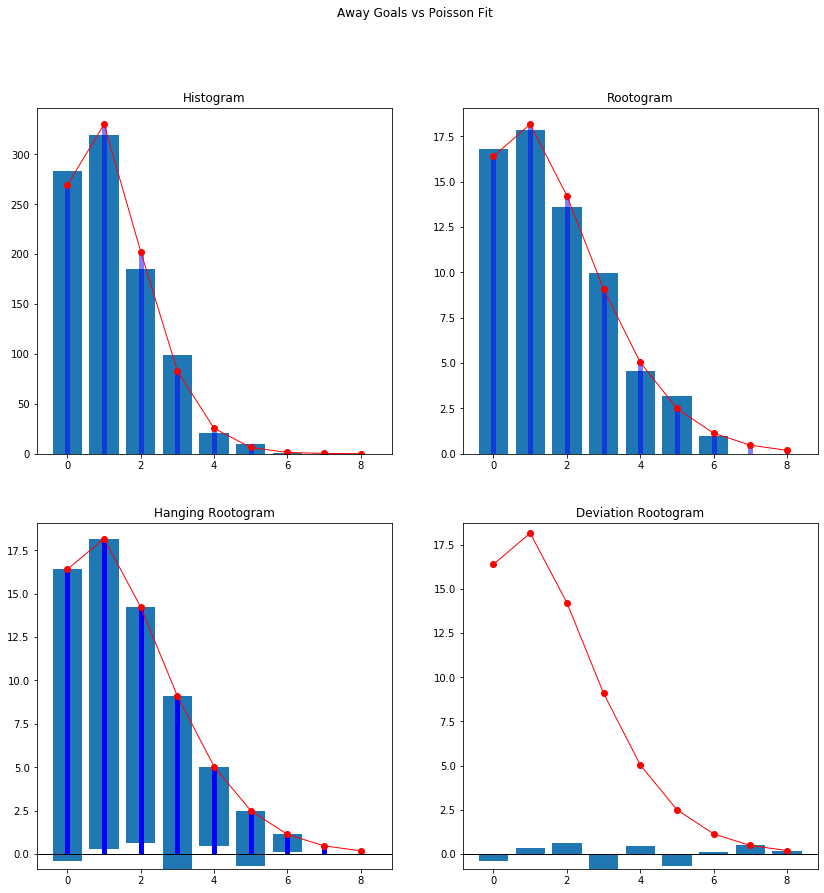

In [13]:
# plt.style.use('fivethirtyeight')
fig, axes = diagnose_discrete_fit(a_goals_poiss.index,
                                  a_goals_poiss['obs'],
                                  a_goals_poiss['exp'])
plt.suptitle('Away Goals vs Poisson Fit')

plt.show();

### Home Goals Negative Binomial Distribution Fit

In [14]:
# Fit the negative binomial to estimate the parameters
param_dict = fit_nbinom(df['h_ftGoals'])
print(param_dict)

{'size': 15.934464401921002, 'prob': 0.9073305966633636}


In [15]:
# Check that we are on the right track by plugging the params into stats and comparing them to what we know 
#from scipy.stats import nbinom
# Get the expected values of a Negative Binomial distribution with the n, psame mu
# mean, var, skew, kurt = nbinom.stats(n, p, moments='mvsk')
mean, var, skew, kurt = stats.nbinom.stats(param_dict['size'], param_dict['prob'], moments='mvsk')
print(f'mean:\t\t{mean}\tvariance:\t{var}')
print(f'h_goals_mean:\t{h_goals_mean}\th_goals_var:\t{h_goals_var}')

mean:		1.627452346526294	variance:	1.7936707441710014
h_goals_mean:	1.6274509803921569	h_goals_var:	1.7956251202770903


In [16]:
#norm_exp = stats.nbinom.pmf(k, n, p, loc=0)
norm_exp = stats.nbinom.pmf(goals_dists.index, param_dict['size'], param_dict['prob'])

exp = norm_exp * goals_dists['h_ftGoals'].sum()
h_goals_nbinom = pd.DataFrame(np.vstack([goals_dists['h_ftGoals'].values, exp, norm_exp])).T
h_goals_nbinom.rename(columns={0:'obs', 1:'exp', 2: 'exp_norm' }, inplace=True)
h_goals_nbinom['obs_norm'] = h_goals_nbinom['obs']/ h_goals_nbinom['obs'].sum()
h_goals_nbinom

,obs,exp,exp_norm,obs_norm
0,191.0,194.921363,0.212333,0.208061
1,292.0,287.828158,0.313538,0.318083
2,237.0,225.845330,0.246019,0.258170
3,106.0,125.116515,0.136292,0.115468
4,62.0,54.883783,0.059786,0.067538
5,22.0,20.277526,0.022089,0.023965
6,5.0,6.556347,0.007142,0.005447
7,2.0,1.903826,0.002074,0.002179
8,1.0,0.505781,0.000551,0.001089


In [17]:
# Use a Chi squared Test
# and KS Test - maybe not suitable for discrete distributions?

chi2 = stats.power_divergence(h_goals_nbinom['obs'],
                              f_exp=h_goals_nbinom['exp'],
                              lambda_="pearson",
                             ddof=1, axis=0)
#ks = stats.kstest(h_goals_nbinom['obs'],
#                  'poisson',
#                  [h_goals_nbinom])

print(f'Pearson:\n{chi2}\n')
#print(f'KS:\n{ks}\n')

Pearson:
Power_divergenceResult(statistic=5.5373290761732, pvalue=0.5946851788246693)



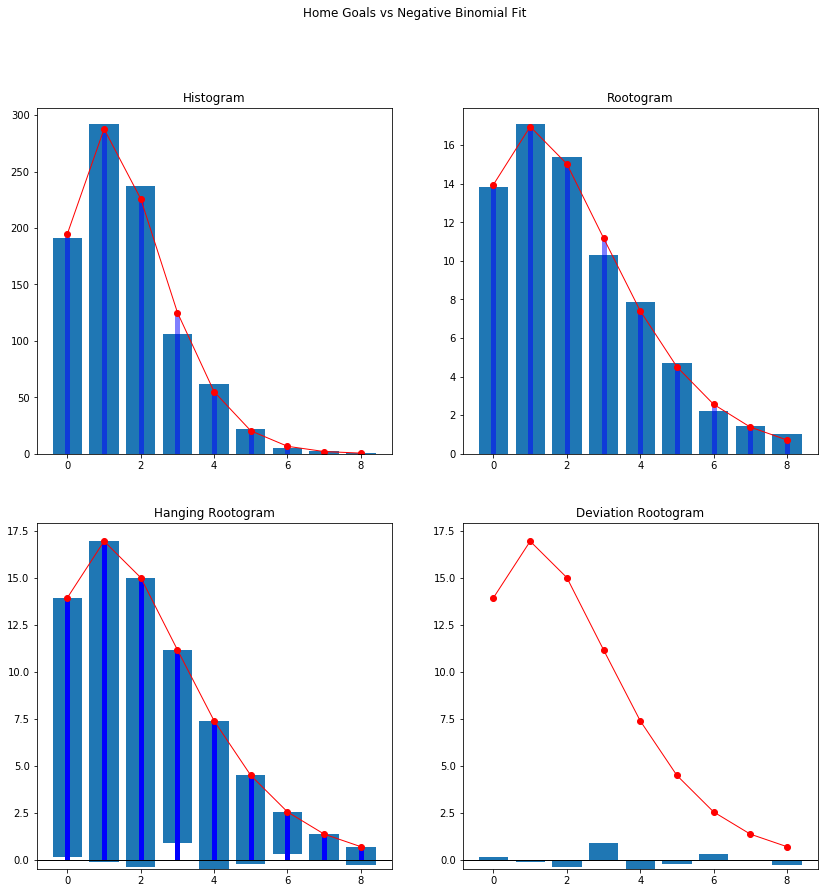

In [18]:
# plt.style.use('fivethirtyeight')
fig, axes = diagnose_discrete_fit(h_goals_nbinom.index,
                                  h_goals_nbinom['obs'],
                                  h_goals_nbinom['exp'])
plt.suptitle('Home Goals vs Negative Binomial Fit')

plt.show();

### Method 2 to estimate parameters

**Thinking about Negative Binomial Distributions**

We'll consider a negative binomial distribution like this.

+ An alternative to the Poisson Distribution where the variance of the distribution is greater than the mean

Simple Version of Method of Moments Estimators for Negative Binomial Parameters

$$ \hat p = \frac {\bar x}{s^2}$$

$$ \hat n = \frac {\bar x ^ 2}{s^2 - \bar x}$$

where:
+ $x$  is sample mean of the observed distribution
+ $s^2$ is the sample variance of the observed distribution

In [19]:
p = h_goals_mean/(h_goals_var)
n = h_goals_mean**2/ (h_goals_var - h_goals_mean)
param_dict = fit_nbinom(df['h_ftGoals'])

print(f'p:\t{p}')
print(f'n:\t{n}')

p:	0.9063422882728541
n:	15.749131795123738


In [20]:
print(f'Home Mean Goals:\t{h_goals_mean}')
print(f'Home Mean variance:\t{h_goals_var}\n')

mean, var, skew, kurt = stats.nbinom.stats(n, p, moments='mvsk')
# Check that we are on the right track by plugging the params into stats and comparing them to what we know 
#from scipy.stats import nbinom
# Get the expected values of a Negative Binomial distribution with the n, psame mu
# mean, var, skew, kurt = nbinom.stats(n, p, moments='mvsk')
print(f'mean:\t\t{mean}\tvariance:\t{var}')
print(f'h_goals_mean:\t{h_goals_mean}\th_goals_var:\t{h_goals_var}')

Home Mean Goals:	1.6274509803921569
Home Mean variance:	1.7956251202770903

mean:		1.627450980392157	variance:	1.7956251202770905
h_goals_mean:	1.6274509803921569	h_goals_var:	1.7956251202770903


In [21]:
# These look good for a lot less effort

In [22]:
#norm_exp = stats.nbinom.pmf(k, n, p, loc=0)
norm_exp2 = stats.nbinom.pmf(goals_dists.index, n, p)

exp2 = norm_exp2 * goals_dists['h_ftGoals'].sum()
h_goals_nbinom2 = pd.DataFrame(np.vstack([goals_dists['h_ftGoals'].values, exp2, norm_exp2])).T
h_goals_nbinom2.rename(columns={0:'obs', 1:'exp', 2: 'exp_norm' }, inplace=True)
h_goals_nbinom2['obs_norm'] = h_goals_nbinom2['obs']/ h_goals_nbinom2['obs'].sum()
h_goals_nbinom2

,obs,exp,exp_norm,obs_norm
0,191.0,195.088918,0.212515,0.208061
1,292.0,287.761548,0.313466,0.318083
2,237.0,225.703663,0.245865,0.258170
3,106.0,125.065640,0.136237,0.115468
4,62.0,54.903840,0.059808,0.067538
5,22.0,20.310671,0.022125,0.023965
6,5.0,6.578343,0.007166,0.005447
7,2.0,1.914273,0.002085,0.002179
8,1.0,0.509826,0.000555,0.001089


In [23]:
# Use a Chi squared Test
# and KS Test - maybe not suitable for discrete distributions?

chi2 = stats.power_divergence(h_goals_nbinom2['obs'],
                              f_exp=h_goals_nbinom2['exp'],
                              lambda_="pearson",
                             ddof=1, axis=0)
#ks = stats.kstest(h_goals_nbinom['obs'],
#                  'poisson',
#                  [h_goals_nbinom])

print(f'Pearson:\n{chi2}\n')
#print(f'KS:\n{ks}\n')

Pearson:
Power_divergenceResult(statistic=5.531443155275767, pvalue=0.5953939893219832)



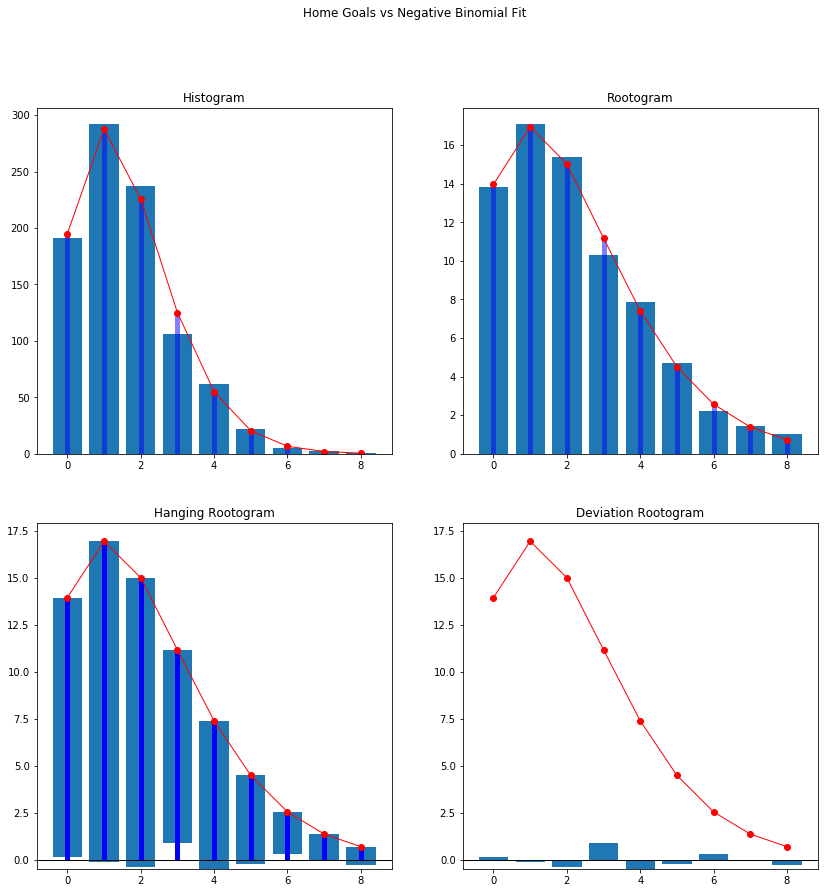

In [24]:
# plt.style.use('fivethirtyeight')
fig, axes = diagnose_discrete_fit(h_goals_nbinom2.index,
                                  h_goals_nbinom2['obs'],
                                  h_goals_nbinom2['exp'])
plt.suptitle('Home Goals vs Negative Binomial Fit')

plt.show();

### Away Goals negative Binomial Fit

Use Simple Version of Method of Moments Estimators for Negative Binomial Parameters (Method 2)

$$ \hat p = \frac {\bar x}{s^2}$$

$$ \hat n = \frac {\bar x ^ 2}{s^2 - \bar x}$$

where:
+ $x$  is sample mean of the observed distribution
+ $s^2$ is the sample variance of the observed distribution

In [25]:
p = a_goals_mean/(a_goals_var)
n = a_goals_mean**2/ (a_goals_var - a_goals_mean)
param_dict = fit_nbinom(df['a_ftGoals'])

print(f'p:\t{p}')
print(f'n:\t{n}')

p:	0.9444960758127356
n:	20.872389852329817


In [26]:
print(f'Away Mean Goals:\t{a_goals_mean}')
print(f'Away Mean variance:\t{a_goals_var}\n')

mean, var, skew, kurt = stats.nbinom.stats(n, p, moments='mvsk')
# Check that we are on the right track by plugging the params into stats and comparing them to what we know 
#from scipy.stats import nbinom
# Get the expected values of a Negative Binomial distribution with the n, psame mu
# mean, var, skew, kurt = nbinom.stats(n, p, moments='mvsk')
print(f'mean:\t\t{mean}\tvariance:\t{var}')
print(f'a_goals_mean:\t{a_goals_mean}\ta_goals_var:\t{a_goals_var}')

Away Mean Goals:	1.2265795206971677
Away Mean variance:	1.298660261390393

mean:		1.226579520697165	variance:	1.2986602613903901
a_goals_mean:	1.2265795206971677	a_goals_var:	1.298660261390393


In [27]:
#norm_exp = stats.nbinom.pmf(k, n, p, loc=0)
norm_exp = stats.nbinom.pmf(goals_dists.index, n, p)

exp = norm_exp * goals_dists['a_ftGoals'].sum()
a_goals_nbinom = pd.DataFrame(np.vstack([goals_dists['a_ftGoals'].values, exp, norm_exp])).T
a_goals_nbinom.rename(columns={0:'obs', 1:'exp', 2: 'exp_norm' }, inplace=True)
a_goals_nbinom['obs_norm'] = a_goals_nbinom['obs']/ a_goals_nbinom['obs'].sum()
a_goals_nbinom

,obs,exp,exp_norm,obs_norm
0,283.0,278.747325,0.303646,0.308279
1,319.0,322.928648,0.351774,0.347495
2,185.0,196.018250,0.213528,0.201525
3,99.0,82.948872,0.090358,0.107843
4,21.0,27.477049,0.029931,0.022876
5,10.0,7.586497,0.008264,0.010893
6,1.0,1.815726,0.001978,0.001089
7,0.0,0.386885,0.000421,0.000000
8,0.0,0.074815,0.000081,0.000000


In [28]:
# Use a Chi squared Test
# and KS Test - maybe not suitable for discrete distributions?

chi2 = stats.power_divergence(a_goals_nbinom['obs'],
                              f_exp=a_goals_nbinom['exp'],
                              lambda_="pearson",
                             ddof=1, axis=0)
#ks = stats.kstest(h_goals_nbinom['obs'],
#                  'poisson',
#                  [h_goals_nbinom])

print(f'Pearson:\n{chi2}\n')
#print(f'KS:\n{ks}\n')

Pearson:
Power_divergenceResult(statistic=6.960797360589129, pvalue=0.4329730249159527)



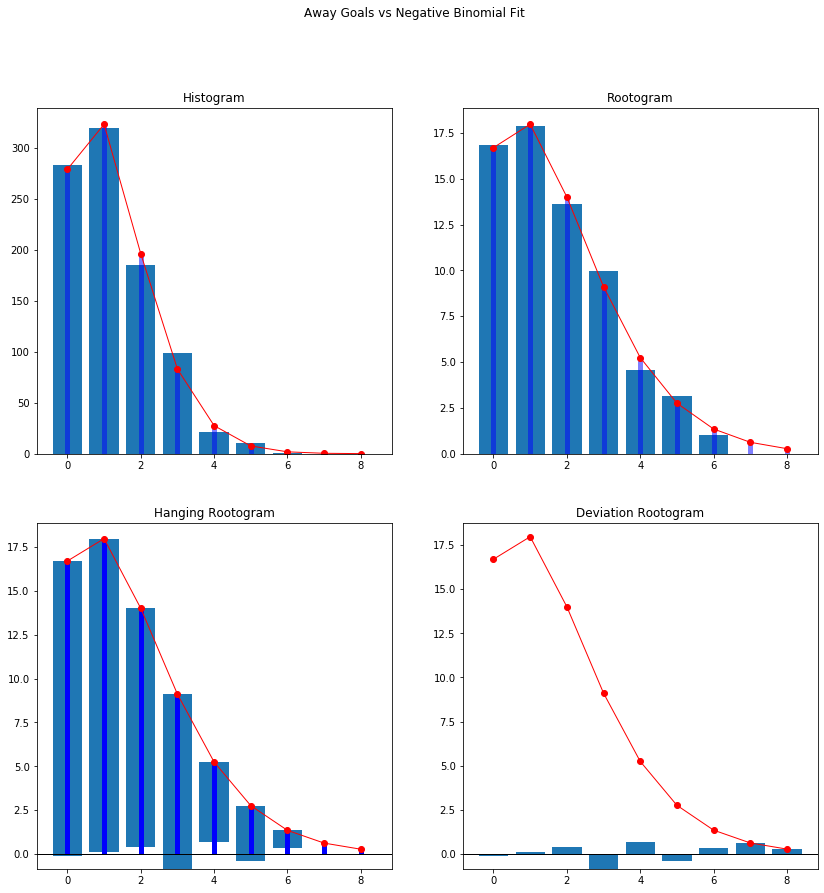

In [29]:
# plt.style.use('fivethirtyeight')
fig, axes = diagnose_discrete_fit(a_goals_nbinom.index,
                                  a_goals_nbinom['obs'],
                                  a_goals_nbinom['exp'])
plt.suptitle('Away Goals vs Negative Binomial Fit')

plt.show();

### References

Visualizing Categorical Data by Michael Friendly - Copyright SAS Institute - ISBN 1-58025-660-0

https://stats.stackexchange.com/questions/78139/how-to-know-if-a-data-follows-a-poisson-distribution-in-r

https://stats.stackexchange.com/questions/328803/python-test-if-my-data-follow-a-poisson-exponential-distribution

https://blogs.sas.com/content/iml/2012/04/12/the-poissonness-plot-a-goodness-of-fit-diagnostic.html

https://github.com/gokceneraslan/fit_nbinom/blob/master/fit_nbinom.py